# ReAct Agent          

#### DAG (Direct Acyclic Graph)         
#### Cyclic Graph

### ReAct Agent

In [5]:
import os
from dotenv import load_dotenv
load_dotenv
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = "pr-respectful-recapitulation-78"

In [6]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(name="o3-mini-2025-01-31",
                 api_key=OPENAI_API_KEY)

In [7]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Annotated

from IPython.display import Image, display

In [ ]:
class AgentState(TypedDict):
    query : str
    messages : Annotated[BaseMessage, add_messages]

In [9]:
@tool
def add(a:float, b:float)->float:
    """This is a addition function that can be used to add two floting point numbers"""
    return a + b

@tool
def sub(a:float, b:float)->float:
    """This is a subtraction function that can be used to subtract two floting point numbers"""
    return a - b

@tool
def mult(a:float, b:float)->float:
    """This is a multiplication function that can be used to multiply two floting point numbers"""
    return a * b

@tool
def divide(a:float, b:float)->float:
    """This is a division function that can be used to divide two floting point numbers"""
    return a / b

tools = [add, sub, mult, divide]

In [17]:
llm_tools = llm.bind_tools(tools)

response = llm_tools.invoke("Can u divide 10 by 4")
response, response.tool_calls, response.additional_kwargs

(AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Q3dDy63ALOfizLZkzQpKS57y', 'function': {'arguments': '{"a":10,"b":4}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 171, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtBSIdqameU1wDndTvccOv2yIvM1i', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c0f8b280-07fe-455d-a259-aced85bafa53-0', tool_calls=[{'name': 'divide', 'args': {'a': 10, 'b': 4}, 'id': 'call_Q3dDy63ALOfizLZkzQpKS57y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 171, 'output_tokens': 17, 'total_tokens': 188, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [11]:
response = llm_tools.invoke("Hello?")
response, response.tool_calls

(AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 165, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtBEyIGUJ9HR6ALqTyVWp3xaIAvEN', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--aeeb3f45-96d9-480c-9cd5-fe52a69e8cc7-0', usage_metadata={'input_tokens': 165, 'output_tokens': 11, 'total_tokens': 176, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 [])

In [12]:
def setup_node(state:AgentState)->AgentState:
    state['messages'] = [ 
        SystemMessage(content="You are agent who helps people to do arithmatic operations with the help of tools provided."),
        HumanMessage(content=state['query'])
    ]
    return state

def agent_node(state:AgentState)->AgentState:
    response = llm_tools.invoke(state['messages'])
    state['messages'] = response
    return state

tool_node = ToolNode(tools)

    
def conditional_tool_agent_edge(state:AgentState)->str:
    last_messages = state['messages'][-1]
    if last_messages.tool_calls:
        return 'tool call'
    else:
        return 'exit'
    

In [13]:
graph = StateGraph(state_schema=AgentState)


#nodes
graph.add_node('setup', setup_node)
graph.add_node('agent', agent_node)
graph.add_node('tools', tool_node)

#edges
graph.add_edge(START, 'setup')
graph.add_edge('setup', 'agent')
graph.add_edge('tools', 'agent')
graph.add_conditional_edges(source='agent',
                            path=conditional_tool_agent_edge,
                            path_map={'tool call':'tools',
                                      'exit' : END})

app = graph.compile()



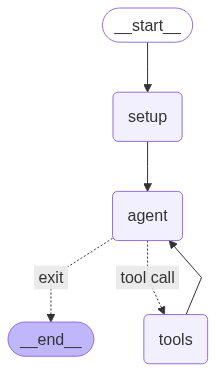

In [14]:
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
response = app.stream({'query': "If George has 3 apples and if I take 2 how many apples does George have?", 'messages':[]}, stream_mode='values')
for res in response:
    message = res['messages'][-1] if res['messages'] else ()
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

()
================================ Human Message =================================

If George has 3 apples and if I take 2 how many apples does George have?
================================== Ai Message ==================================
Tool Calls:
  sub (call_4IOwxFnNKG0qXaXzXT90Tuue)
 Call ID: call_4IOwxFnNKG0qXaXzXT90Tuue
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: sub

1.0
================================== Ai Message ==================================

If you take 2 apples from George, he will have 1 apple left.


### Return Direct 
* End directly       
* Return direct can be used output a tools output without going back to the agent.

### Dynamic Return Direct        
* End directly conditionally.

### Specific Output Format        
* Output a specific foramt rather than the state format.         
* There are two methods - 
    1. Define a function that transforms the agent state to the desired and attach it as a tool.
    2. Use a different node and a LLM with structured output and convert the agent state to desired output.

##### Option 1 - Bind Output as Tool          
- When a tool that requires a specific output format agtent llm formats the to the strucutured output.          
- Then this structure can be used to respond to the user using a different node.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = "pr-respectful-recapitulation-78"

In [55]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(name="gpt-4o-mini-2024-07-18",
                 temperature= 0.0,
                 api_key=OPENAI_API_KEY)

In [39]:
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from typing import TypedDict, Dict, Annotated
from pydantic import BaseModel, Field

from IPython.display import Image, display

In [139]:
class FinalResponse(BaseModel):
    """Respond to the user after all calculations."""
    steps : list[str] = Field(description="A list of steps describing each step clearly that was carried out to solve the problem.")
    answer : str = Field(description="Final answer to the querstion as a one line sentence.")

In [140]:
class AgentState(TypedDict):
    query : str
    messages : Annotated[BaseMessage, add_messages]
    final_response : FinalResponse | None

In [141]:
@tool
def add(a:float, b:float)->float:
    """This is a addition function that can be used to add two floting point numbers"""
    return a + b

@tool
def sub(a:float, b:float)->float:
    """This is a subtraction function that can be used to subtract two floting point numbers"""
    return a - b

@tool
def mult(a:float, b:float)->float:
    """This is a multiplication function that can be used to multiply two floting point numbers"""
    return a * b

@tool
def divide(a:float, b:float)->float:
    """This is a division function that can be used to divide two floting point numbers"""
    return a / b

#@tool
#def respond(a:CalcDescription):
#    """This tool is used to format the final output describing all the steps taken to do the calculations"""
#    return None

tools = [add, sub, mult, divide, FinalResponse]

In [142]:
llm_tools = llm.bind_tools(tools)

In [143]:
query = "James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?"
#response = llm_tools.invoke("James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?")
#response

In [146]:
def setup_node(state:AgentState)->AgentState:
    system_prompt_str = """
- You are a helpful assistant who helps kids perform multi-stage calculations.
- Break down complex problems into simple, easy-to-follow steps.
- Always use the provided tools for calculations and to output the final output after calculations.
    """
    state['messages'] = [SystemMessage(content=system_prompt_str),
                         HumanMessage(content=f"{state['query']}")]
    return state
    
def agent_node(state:AgentState)->AgentState:
    response = llm_tools.invoke(state['messages'])
    state['messages'] = [response]
    return state

def respond_node(state:AgentState)->AgentState:
    last_message = state['messages'][-1]
    #print(last_message)
    last_tool_call = last_message.tool_calls[0]
    final_response = FinalResponse(**last_tool_call['args'])
    state['final_response'] = final_response
    return state

tool_node = ToolNode(tools)

In [147]:
def route(state:AgentState)->str:
    last_tool_call = state['messages'][-1].tool_calls[0]
    tool_name = last_tool_call['name']
    if tool_name=='FinalResponse':
        return 'exit'
    else:
        return 'tool call'

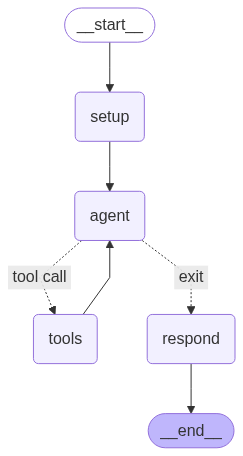

In [148]:
workflow = StateGraph(state_schema=AgentState)

#nodes
workflow.add_node('setup', setup_node)
workflow.add_node('agent', agent_node)
workflow.add_node('tools', tool_node)
workflow.add_node('respond',respond_node)

#edges
workflow.add_edge(START, 'setup')
workflow.add_edge('setup', 'agent')
workflow.add_edge('tools','agent')
workflow.add_conditional_edges(source='agent',
                               path=route,
                               path_map={'tool call':'tools',
                                         'exit' : 'respond'})
workflow.add_edge('respond', END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [149]:
response = graph.stream({'query': query, 'messages':[]}, stream_mode='values')
for res in response:
    message = res['messages'][-1] if res['messages'] else ()
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

()
================================ Human Message =================================

James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?
================================== Ai Message ==================================
Tool Calls:
  sub (call_IKVKtp221s61keeJku9LrxbB)
 Call ID: call_IKVKtp221s61keeJku9LrxbB
  Args:
    a: 10
    b: 2
  sub (call_KTVOG6Ab8bvl5PoHrpbt2sYr)
 Call ID: call_KTVOG6Ab8bvl5PoHrpbt2sYr
  Args:
    a: 5
    b: 1
================================= Tool Message =================================
Name: sub

4.0
================================== Ai Message ==================================
Tool Calls:
  FinalResponse (call_5T2KSYkuu8fk8FnPrvSgH0MS)
 Call ID: call_5T2KSYkuu8fk8FnPrvSgH0MS
  Args:
    steps: ['James had 10 apples and 5 oranges.', 'George took 2 apples and 1 orange from James.', 'Subtracting 2 apples from 10 apples, James now has 8 apples.', 'Subtracting 1 orange from 5 oranges, Ja

In [150]:
response = graph.invoke({'query':query})

In [151]:
for i, step in enumerate(response['final_response'].steps):
    print(f"Step {i+1} - \n{step}")
print(f"\nAnswer : {response['final_response'].answer}")

Step 1 - 
James had 10 apples and 5 oranges.
Step 2 - 
George took 2 apples and 1 orange from James.
Step 3 - 
Subtracting 2 apples from 10 apples, James now has 8 apples.
Step 4 - 
Subtracting 1 orange from 5 oranges, James now has 4 oranges.

Answer : James now has 8 apples and 4 oranges.


##### Option 2 - With structured Output LLM          
- Respond node is added with a llm with a structured output attached to it.

In [152]:
import os
from dotenv import load_dotenv
load_dotenv
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = "pr-respectful-recapitulation-78"

In [153]:
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from typing import TypedDict, Dict, Annotated
from pydantic import BaseModel, Field

from IPython.display import Image, display

In [154]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(name="gpt-4o-mini-2024-07-18",
                 temperature= 0.0,
                 api_key=OPENAI_API_KEY)

In [155]:
class FinalResponse(BaseModel):
    """Respond to the user after all calculations."""
    steps : list[str] = Field(description="A list of steps describing each step clearly that was carried out to solve the problem.")
    answer : str = Field(description="Final answer to the querstion as a one line sentence.")

In [158]:
class AgentState(TypedDict):
    query : str
    messages : Annotated[BaseMessage, add_messages]
    final_response : FinalResponse

In [159]:
@tool
def add(a:float, b:float)->float:
    """This is a addition function that can be used to add two floting point numbers"""
    return a + b

@tool
def sub(a:float, b:float)->float:
    """This is a subtraction function that can be used to subtract two floting point numbers"""
    return a - b

@tool
def mult(a:float, b:float)->float:
    """This is a multiplication function that can be used to multiply two floting point numbers"""
    return a * b

@tool
def divide(a:float, b:float)->float:
    """This is a division function that can be used to divide two floting point numbers"""
    return a / b

tools = [add, sub, mult, divide]

In [160]:
llm_tools = llm.bind_tools(tools)

llm_str_output = llm.with_structured_output(FinalResponse)

d:\lang-graph-agents\venv\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [169]:
def setup_node(state:AgentState)->AgentState:
    system_prompt_str = """
- You are a helpful assistant who helps kids perform multi-stage calculations.
- Break down complex problems into simple, easy-to-follow steps.
- Always use the provided tools for calculations and to output the final output after calculations.
    """
    state['messages'] = [SystemMessage(content=system_prompt_str),
                         HumanMessage(content=f"{state['query']}")]
    return state
    
def agent_node(state:AgentState)->AgentState:
    response = llm_tools.invoke(state['messages'])
    state['messages'] = [response]
    return state

def respond_node(state:AgentState)->AgentState:
    system_prompt_str = """
- You are a helpful assistant who helps kids perform multi-stage calculations.

- Below is a conversation between an agent, human and tools carrying out the calculation in steps.

- Your job is to list the steps and provide the final answer.
    """
    messages = [SystemMessage(content=system_prompt_str)] + state['messages'][1:]
    response = llm_str_output.invoke(messages)
    state['final_response'] = response
    return state

tool_node = ToolNode(tools)

In [170]:
def route(state:AgentState)->str:
    last_tool_call = state['messages'][-1].tool_calls
    if not last_tool_call:
        return 'exit'
    else:
        return 'tool call'

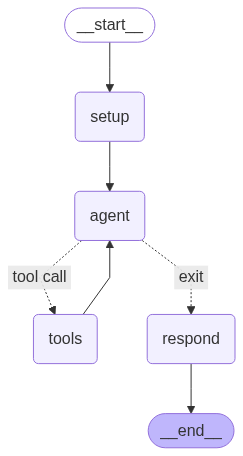

In [171]:
workflow = StateGraph(state_schema=AgentState)

#nodes
workflow.add_node('setup', setup_node)
workflow.add_node('agent', agent_node)
workflow.add_node('tools', tool_node)
workflow.add_node('respond',respond_node)

#edges
workflow.add_edge(START, 'setup')
workflow.add_edge('setup', 'agent')
workflow.add_edge('tools','agent')
workflow.add_conditional_edges(source='agent',
                               path=route,
                               path_map={'tool call':'tools',
                                         'exit' : 'respond'})
workflow.add_edge('respond', END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [172]:
response = graph.invoke({'query': query, 'messages':[]})
response, type(response)

({'query': 'James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?',
  'messages': [SystemMessage(content='\n- You are a helpful assistant who helps kids perform multi-stage calculations.\n- Break down complex problems into simple, easy-to-follow steps.\n- Always use the provided tools for calculations and to output the final output after calculations.\n    ', additional_kwargs={}, response_metadata={}, id='9d8ab50a-0de5-4910-813f-88eb2bf9bf1f'),
   HumanMessage(content='James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?', additional_kwargs={}, response_metadata={}, id='6f5afbb2-42bb-41f5-a47b-99bf9b954a58'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YDjg4sXibyZdVTtLfIEhcUUx', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'sub'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'comp

In [174]:
response['final_response'].steps

['James had 10 apples and 5 oranges.',
 'George took 2 apples and 1 orange from James.',
 'Subtracting 2 from 10, James now has 8 apples.',
 'Subtracting 1 from 5, James now has 4 oranges.']

In [175]:
response['final_response'].answer

'James now has 8 apples and 4 oranges.'

### Force Tool Call

### Breakpoints

### Configuration

### Streaming